SETUP

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import qkeras
from qkeras import *

In [2]:
X = np.load("/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/bnb_WithWire_00_pureNu_batch_00_10X4.npy")

In [3]:
X.shape

(2560, 864, 64, 1)

In [4]:
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

In [5]:
#model = keras.models.load_model("noQDB_seq", custom_objects=co)
teacher = keras.models.load_model('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/teacher_10X4')
student_test = qkeras.utils.load_qmodel('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/student_sequential_10X4')

In [6]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 teacher_inputs_ (InputLaye  [(None, 864, 64, 1)]      0         
 r)                                                              
                                                                 
 teacher_reshape (Reshape)   (None, 864, 64, 1)        0         
                                                                 
 teacher_conv2d_1 (Conv2D)   (None, 864, 64, 20)       200       
                                                                 
 teacher_relu_1 (Activation  (None, 864, 64, 20)       0         
 )                                                               
                                                                 
 teacher_pool_1 (AveragePoo  (None, 432, 32, 20)       0         
 ling2D)                                                         
                                                           

In [7]:
student_test.summary()

Model: "cicada-v2-seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 864, 64, 1)        0         
                                                                 
 conv (QConv2D)              (None, 432, 32, 4)        16        
                                                                 
 relu0 (QActivation)         (None, 432, 32, 4)        0         
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dropout (Dropout)           (None, 55296)             0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                884817    
                                                                 
 relu1 (QActivation)         (None, 16)              

In [8]:
import hls4ml
import QDenseBatchnorm


In [9]:
config = hls4ml.utils.config_from_keras_model(student_test, backend='Vitis', 
                                              default_precision='fixed<32,16>',
                                              granularity='name')

Interpreting Sequential
Topology:
Layer name: reshape_input, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

In [11]:
config

{'Model': {'Precision': 'fixed<32,16>',
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'reshape_input': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>'}},
  'reshape': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'conv': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'weight': 'fixed<16,5>',
    'bias': 'fixed<32,16>',
    'accum': 'fixed<32,16>'},
   'ReuseFactor': 1,
   'ParallelizationFactor': 1,
   'ConvImplementation': 'LineBuffer'},
  'conv_linear': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>', 'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'relu0': {'Trace': True,
   'Precision': {'result': 'ufixed<10,6,RND_CONV,SAT>',
    'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'flatten': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'dense1': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'we

In [12]:
hls_model = hls4ml.converters.convert_from_keras_model(student_test,
                                                       hls_config=config,
                                                       io_type='io_parallel',
                                                       output_dir=f'complex_hls4mlproj')

Interpreting Sequential
Topology:
Layer name: reshape_input, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model


In [13]:
X_flat = X.reshape((2560,-1))

In [14]:
X_flat.shape

(2560, 55296)

In [15]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

ntimeticks = 6400
nwire = 3456
f_downsample = 10
h_split = 10
v_split = 4
nbatch = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

adccutoff = 10.*f_downsample/10.
adcsaturation = 100.*f_downsample/10.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


COMPILING AND PREDICTING

In [17]:
#Y = student_test.predict(X_flat)

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
X_student = X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1))
Y = student_test.predict(X_student).reshape(len(X_loss_teacher))


80/80 [==============================] - 1s 11ms/step


In [18]:
hls_model.compile()

Writing HLS project


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [19]:
fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)

Recompiling myproject with tracing
Writing HLS project
Done


In [20]:
#Y_hls = hls_model.predict(X_flat)
y_predict_hls4ml_q = hls_model.predict(np.ascontiguousarray(X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1)))).reshape(len(X_loss_teacher))


RESULTS

In [21]:
for j in Y:
    print(j)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [22]:
for i in y_predict_hls4ml_q:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [23]:
import matplotlib.pyplot as plt

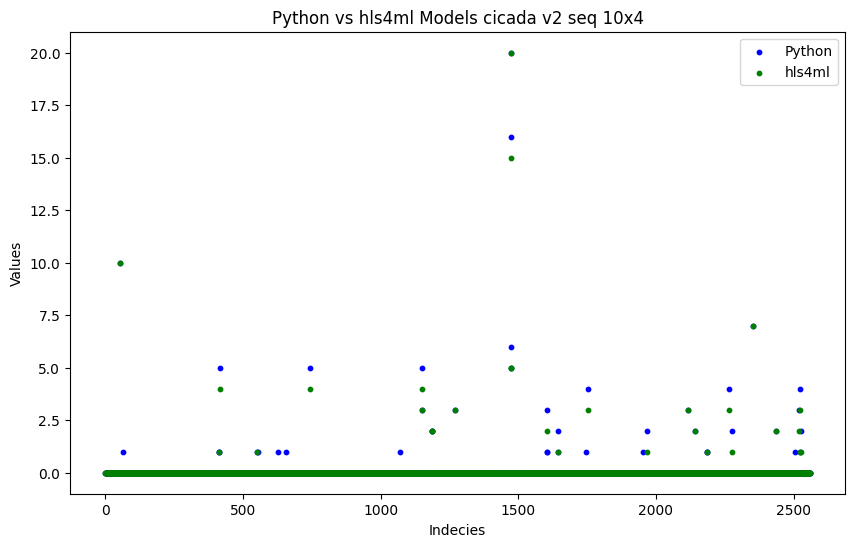

In [24]:
differences = [pred1 != pred2 for pred1, pred2 in zip(Y, y_predict_hls4ml_q)]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y)), Y, color='blue', s=10, label='Python')
plt.scatter(range(len(y_predict_hls4ml_q)), y_predict_hls4ml_q, color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Values')
plt.title('Python vs hls4ml Models cicada v2 seq 10x4')
plt.legend()
plt.show()
# Labels and title

In [25]:
off_list = np.argwhere(~np.isclose(Y, y_predict_hls4ml_q))

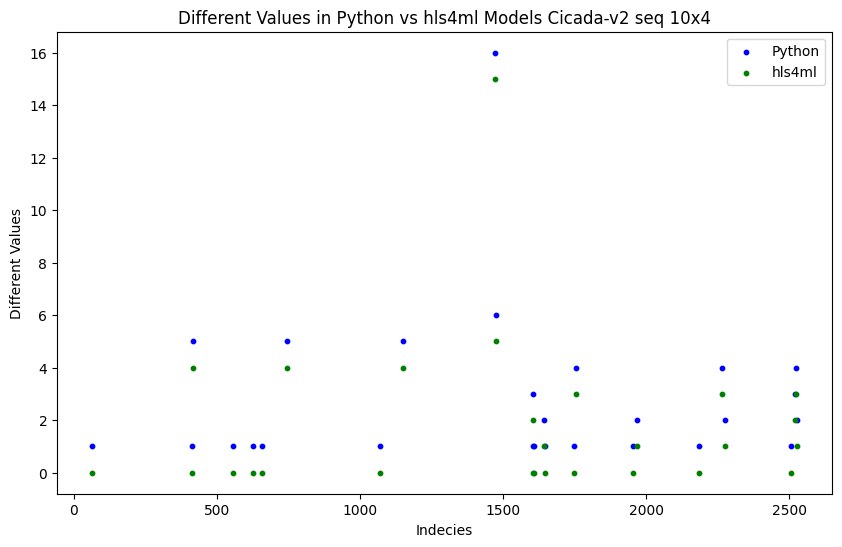

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(off_list, Y[off_list], color='blue', s=10, label='Python')
plt.scatter(off_list, y_predict_hls4ml_q[off_list], color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Different Values')
plt.title('Different Values in Python vs hls4ml Models Cicada-v2 seq 10x4')
plt.legend()
plt.show()

In [27]:
non_zero_list = np.argwhere(~np.isclose(0.0, y_predict_hls4ml_q))

In [28]:
len(off_list)

27

In [29]:
len(non_zero_list)

29

In [30]:
off_list_indexes = []
for k in off_list:
    off_list_indexes.append(k[0])

for ind in off_list_indexes:
    print("Y: ")
    print(Y[ind])
    print("hls pred: ")
    print(y_predict_hls4ml_q[ind])

Y: 
1.0
hls pred: 
0.0
Y: 
1.0
hls pred: 
0.0
Y: 
5.0
hls pred: 
4.0
Y: 
1.0
hls pred: 
0.0
Y: 
1.0
hls pred: 
0.0
Y: 
1.0
hls pred: 
0.0
Y: 
5.0
hls pred: 
4.0
Y: 
1.0
hls pred: 
0.0
Y: 
5.0
hls pred: 
4.0
Y: 
16.0
hls pred: 
15.0
Y: 
6.0
hls pred: 
5.0
Y: 
3.0
hls pred: 
2.0
Y: 
1.0
hls pred: 
0.0
Y: 
1.0
hls pred: 
0.0
Y: 
2.0
hls pred: 
1.0
Y: 
1.0
hls pred: 
0.0
Y: 
1.0
hls pred: 
0.0
Y: 
4.0
hls pred: 
3.0
Y: 
1.0
hls pred: 
0.0
Y: 
2.0
hls pred: 
1.0
Y: 
1.0
hls pred: 
0.0
Y: 
4.0
hls pred: 
3.0
Y: 
2.0
hls pred: 
1.0
Y: 
1.0
hls pred: 
0.0
Y: 
3.0
hls pred: 
2.0
Y: 
4.0
hls pred: 
3.0
Y: 
2.0
hls pred: 
1.0


In [31]:
diff_sum = 0

for ind in off_list_indexes:
    diff = abs(Y[ind]-y_predict_hls4ml_q[ind])
    diff_sum = diff+diff_sum

diff_avg = diff_sum/len(off_list)

In [32]:
print(diff_avg)

1.0


In [33]:
diff_pct = []
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    if Y[ind]==0:
        temp_diff_pct = diff
    else:
        temp_diff_pct = diff/Y[ind]
    diff_pct.append(temp_diff_pct)

In [34]:
diff_pct_avg = sum(diff_pct)/len(diff_pct)
print(diff_pct_avg)

0.6387345679012346


In [29]:
np.allclose(Y, y_predict_hls4ml_q, atol=1)

True

WEIGHTS

Interpreting Sequential
Topology:
Layer name: reshape_input, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Profiling weight

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

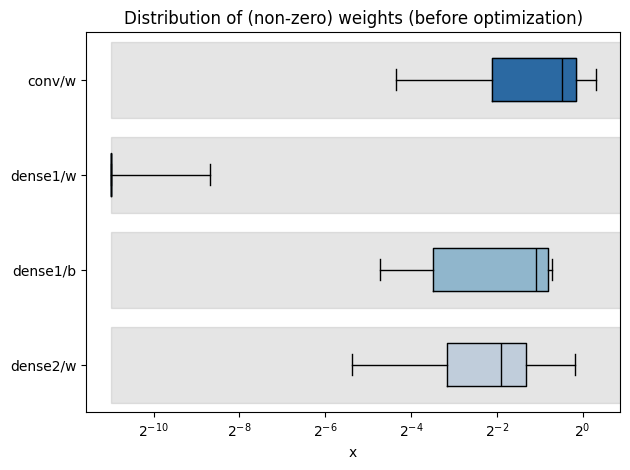

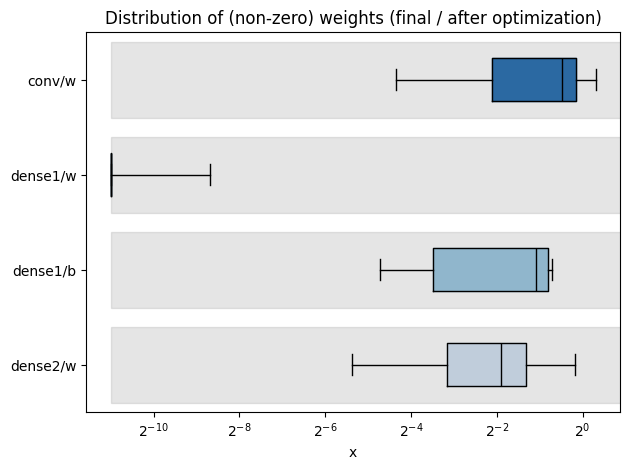

In [25]:
hls4ml.model.profiling.numerical(model=student_test, hls_model=hls_model)

In [26]:
print(hls4ml_trace)

{}


In [27]:
layers = student_test.layers
conv_weights = student_test.layers[1].get_weights()
dense_weights = student_test.layers[8].get_weights()
qdensebatchnorm_weights = student_test.layers[6].get_weights()
print(layers)
print(conv_weights)
print(dense_weights)
print(qdensebatchnorm_weights)

[<keras.src.layers.reshaping.reshape.Reshape object at 0x16d7199c0>, <qkeras.qconvolutional.QConv2D object at 0x16d6bdd20>, <qkeras.qlayers.QActivation object at 0x16d75aa70>, <keras.src.layers.reshaping.flatten.Flatten object at 0x16d75b0a0>, <keras.src.layers.regularization.dropout.Dropout object at 0x16d75b490>, <qkeras.qdense_batchnorm.QDenseBatchnorm object at 0x16d75b4c0>, <qkeras.qlayers.QActivation object at 0x16d703340>, <keras.src.layers.regularization.dropout.Dropout object at 0x16d086680>, <qkeras.qlayers.QDense object at 0x16d7c90f0>, <qkeras.qlayers.QActivation object at 0x16d7caad0>]
[array([[[[ 0.1031297 , -1.0433979 ,  0.2631576 ,  0.62538505]],

        [[ 1.236919  , -0.6691066 , -1.2184844 , -0.7752788 ]]],


       [[[-1.0286767 , -0.8460969 ,  0.0842438 ,  0.8211138 ]],

        [[ 0.12976919,  0.58964366, -0.85490865,  0.0490555 ]]]],
      dtype=float32)]
[array([[ 0.1137787 ],
       [ 0.82232213],
       [-0.02383308],
       [ 0.36022156],
       [ 0.35828292

In [28]:
#print(min(conv_weights))
conv_weights_list = []
for i in conv_weights[0][0][0][0]:
    conv_weights_list.append(i)
for j in conv_weights[0][1][0][0]:
    conv_weights_list.append(j)
print(min(conv_weights_list), max(conv_weights_list))

-1.0433979 0.8211138


In [29]:
print(min(dense_weights[0]), max(dense_weights[0]))

[-0.6183346] [0.8839359]


In [30]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

KeyError: 'XILINX_VIVADO'

In [30]:
hls4ml build -p complex_hls4mlproj

SyntaxError: invalid syntax (3971047448.py, line 1)

In [29]:
hls_model.build(csim=False, synth=True, vsynth=True)

Project myproject_prj does not exist. Rerun "hls4ml build -p complex_hls4mlproj".


sh: vivado_hls: command not found


In [ ]:
from pathlib import Path
import pprint

def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ii'] = int(lat_line.split('|')[6])

    return data_

In [ ]:
data_quantized_pruned = getReports('complex_hls4mlproj')

print("\n Resource usage and latency: ")
pprint.pprint(data_quantized_pruned)